[Next]() | [Prev](Audio_Features_and_Musical_Objects.htm) | [DLfMIR Home](https://iranroman.github.io/DLfMIR)

---

# Chapter 2: Audio Classification Algorithms #

### Subsections ###
1. Using Features to Differentiate Audio Classes
2. Measuring Relationships Between Vectors
3. Developing and Assessing a Naïve Classification Algorithm

### 2.1 Using Features to Differentiate Audio Classes ###
Chapter 1 taught us how to extract spectral features from audio. As you remember, to extract spectral features we used a fomula (when obtaining spectral centroids or bandwidths) or a series of steps (when obtaining the Mel-frequency Cepstral Coefficients). These formulas or steps are objective measurements of the information that an audio file contains. Because of their objectivity, we can use these measurements to study what makes different musical objects unique (e.g. different musical instruments). By extracting these spectral features we can observe, for example, that the spectral centroid of piano sounds tends to be a lower value when compared to the spectral centroid of the sound generated by the human voice. Hence, the spectral centroid can help us to objectively differentiate piano sounds from human voice sounds.

In this chapter we will study classification algorithms, which are methodologies allowing us to automatically separate  objects using their features. To study how classification algorithms work, we will continue using the [IRMAS dataset](https://www.upf.edu/web/mtg/irmas) and the spectral features that we learned in Chapter 1. To get started with this chapter's content, we will reload the small version of the [IRMAS dataset](https://www.upf.edu/web/mtg/irmas).

In [ ]:
# a package to load data in .mat files
Pkg.add("MAT") 
using MAT

# loading a small version of the IRMAS dataset 
iris = matread("IRMAS_small.mat")
fs = 22050 # storing the sampling rate in a variable
T = 1/fs # and the timestep

# obtaining the data and corresponding instrument categories
data = iris["data"][:,1:end-1]
inst_cat = iris["data"][:,end];

At the end of Chapter 1 you found two features that maximally separated the different instrument families (cello, flute, piano, and human singing voice). Use the cell bellow to borrow code from Chapter 1 and store the two features in the vectors called `feat1` (with size 140x1) and `feat2` (also with size 140x1).

In [2]:
# your code and borrowed code here


The cell bellow will plot, in a two dimensional space, all the datapoints in the small version of the [IRMAS dataset](https://www.upf.edu/web/mtg/irmas). Each dimension is one of the features you selected. Rename the x and y axes to reflect the names of the features you selected.

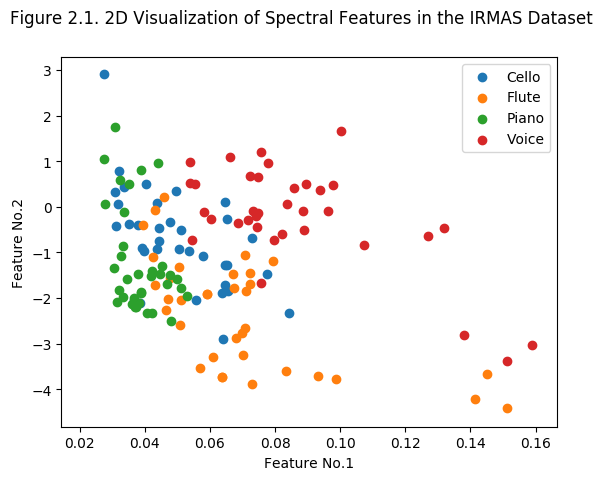

In [3]:
# using inst_cat to identify the row indices of data that correspond to different instrument families.
cell_is = find(x -> x == 1,inst_cat)
flut_is = find(x -> x == 2,inst_cat)
pian_is = find(x -> x == 3,inst_cat)
hvoi_is = find(x -> x == 4,inst_cat)

# generating the plot
using PyPlot
scatter(feat1[cell_is],feat2[cell_is],label = "Cello")
scatter(feat1[flut_is],feat2[flut_is],label = "Flute")
scatter(feat1[pian_is],feat2[pian_is],label = "Piano")
scatter(feat1[hvoi_is],feat2[hvoi_is],label = "Voice")
xlabel("Feature No.1")
ylabel("Feature No.2")
legend();

suptitle("Figure 2.1. 2D Visualization of Spectral Features in the IRMAS Dataset");

Figure 2.1 is a scatter plot where you should see that different instruments tend to occupy different areas of the plot. There might be areas where different instruments overlap, but all instrument should not lay around a single neighborhood of the plot. If this is not what you see, consider using a different pair of spectral features.

We have identified a pair of features that naturally differentiate the musical objects in the small version of the [IRMAS dataset](https://www.upf.edu/web/mtg/irmas). The next step is to formalize the procedure that a computer program could follow to automatically separate these four musical objects using this pair of features. In other words, we will develop a classification algorithm. The next section will help us understand (1) how classification algorithms work and (2) how to objectively assess them.

### 2.1 Measuring Relationships Between Vectors ###
We noticed in figure 2.1 that the four different instruments more or less occupied different areas of the 2D scatter plot. This means that, to some extent, we can expect a datapoint extracted from piano audio to lay closer to another piano datapoint compared to other instrument datapoints. We cannot predict the degree of spread observed among datapoints extracted from a particular instrument type. Instead, we can use the available datapoints calculate an "average" or "template" datapoint for each instrument type. By doing this we can notice that these "average" datapoints lay within the cloud of data that correspons to a particular type of instrument. 

The cell bellow will plot your datapoints as well as the "average" datapoints for each instrument class.

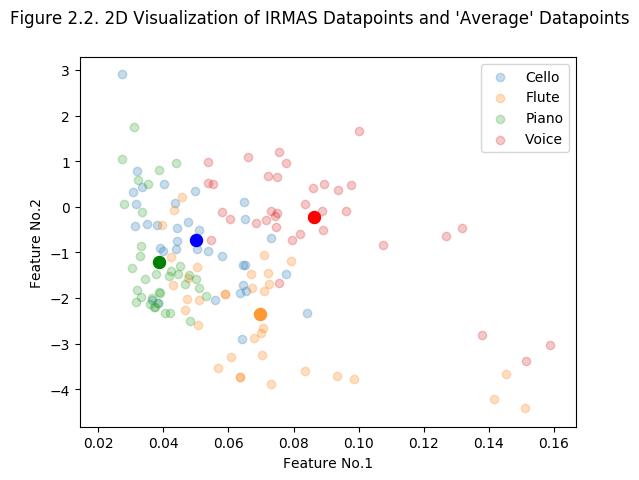

In [4]:
# plot the datapoints again
scatter(feat1[cell_is],feat2[cell_is],label = "Cello",alpha=0.25)
scatter(feat1[flut_is],feat2[flut_is],label = "Flute",alpha=0.25)
scatter(feat1[pian_is],feat2[pian_is],label = "Piano",alpha=0.25)
scatter(feat1[hvoi_is],feat2[hvoi_is],label = "Voice",alpha=0.25)
xlabel("Feature No.1")
ylabel("Feature No.2")
legend();

suptitle("Figure 2.2. 2D Visualization of IRMAS Datapoints and 'Average' Datapoints");

# Calculate the average datapoints
cell_aver = [mean(feat1[cell_is]),mean(feat2[cell_is])]
flut_aver = [mean(feat1[flut_is]),mean(feat2[flut_is])]
pian_aver = [mean(feat1[pian_is]),mean(feat2[pian_is])]
hvoi_aver = [mean(feat1[hvoi_is]),mean(feat2[hvoi_is])]

# Plot the average datapoints
scatter(cell_aver[1],cell_aver[2],s=75,color="b")
scatter(flut_aver[1],flut_aver[2],s=75,color=[1.0 0.6 0.2])
scatter(pian_aver[1],pian_aver[2],s=75,color="g")
scatter(hvoi_aver[1],hvoi_aver[2],s=75,color="r");

How can we use these "average" datapoints for each instrument type? Image that we have a datapoint in this two-dimensional space and that we don't know what instrument it corresponds to. We can calculate the four eucledian distances between this "unknown" datapoint and the four "average" instrument datapoints. Then, we can assume that the "average" instrument datapoint that resulted in the shortest distance with the "unknown" datapoint corresponds to the instrument identity of the "unknown" datapoint.

To explore this idea further. Let's remember the formula of the eucledian distance in a 2D space:

$$ d(a,b) = \sqrt{(a_1-b_1)^2 + (a_2-b_2)^2}$$ 

where $a$ and $b$ are two-dimensional vectors (i.e. $a, b \in \mathbf{R^{1x2}}$) and their eucledian distance is obtained with the formula $d(a,b)$. The underscripts $1$ and $2$ indicate which dimension in $a$ and $b$ is being retrieved. It is worth noting that the function $d(a,b)$ is the formula to calculate the hypothenuse of a triangle. 

In the next cell, calculate the eucledian distance between all the datapoints in the small version of the [IRMAS dataset](https://www.upf.edu/web/mtg/irmas) and the four "average" instrument datapoints calculated previously (i.e. `cell_aver`, `flut_aver`, `pian_aver`, and `hvoi_aver`).



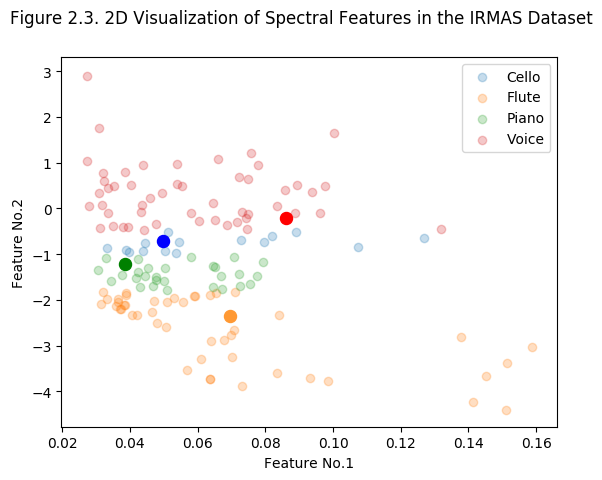

In [5]:
# your code here



Compare figures 2.2 and 2.3. How similar are they from each other? Is the eucledian distance to the "average" instrument datapoints a good way to assess the identity of other datapoints? 

To objetively compare figures 2.2 and 2.3, we can find the number of datapoints that have the same color in both figures. This would tell us the accuracy of identifying datapoints by identifying the shortest distance between such dataponts and one of the "average" instrument datapoints. The following cell does this for you.

In [6]:
print("Precision was: ", 100*sum(inst_cat .== inst_cat_hat')/length(inst_cat_hat), " %")

Precision was: 47.857142857142854 %

There exists an algorithm that exploits the eucledian distance (as well as other kinds of distances) to classify datapoints. This algorithm's name is The K-Nearest Neighbors (KNN) algorithm. [CS231N](http://cs231n.stanford.edu/), another Stanford Neural Networks Course, explains in detail this algorithm, so if you are interested we encourage you to study their explanation of the KNN algorithm [here](http://cs231n.github.io/classification/).

At this point, you might be wondering, what do eucledian distances or the KNN algorithm have to do with neural networks? The short answer is: neural networks optimally find distances between datapoints and "template" datapoints for data classes. However, most neural networks do not use the euclidean distance to carry out this task. Instead, they use another operation known as the dot product, whose formula is:

$$ a \dot{} b = \sum_{i=1}^N a_i b_i$$

Where $a,b \in \mathbf{R}^N$. The dot product finds the degree of similarity between the direction of two vectors. To understand this point, let's look at figure 2.4:

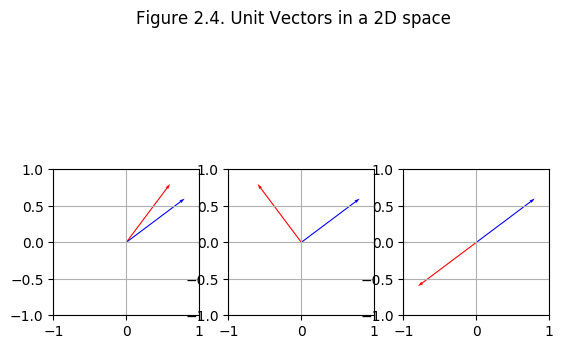

In [41]:
# 2D vectors that we will plot
a = [0.8, 3/5]
b = [0.6, 4/5]

# plotting the vectors
subplot(1,3,1)
quiver(a[1],a[2],angles="xy", scale_units="xy", scale = 1, color="b")
quiver(b[1],b[2],angles="xy", scale_units="xy", scale = 1, color="r")
axis("scaled")
xlim((-1,1))
ylim((-1,1))
grid("on")

# 2D vectors that we will plot
a = [0.8, 3/5];
b = [-3/5, 0.8]

# plotting the vectors
subplot(1,3,2)
quiver(a[1],a[2],angles="xy", scale_units="xy", scale = 1, color="b")
quiver(b[1],b[2],angles="xy", scale_units="xy", scale = 1, color="r")
axis("scaled")
xlim((-1,1))
ylim((-1,1))
grid("on")

# 2D vectors that we will plot
a = [0.8, 3/5];
b = [-0.8, -3/5]

# plotting the vectors
subplot(1,3,3)
quiver(a[1],a[2],angles="xy", scale_units="xy", scale = 1, color="b")
quiver(b[1],b[2],angles="xy", scale_units="xy", scale = 1, color="r")
axis("scaled")
xlim((-1,1))
ylim((-1,1))
grid("on")

suptitle("Figure 2.4. Unit Vectors in a 2D space");

All the vectors in figure 2.4 have a magnitude of 1, but as you can see, the red vectors are pointing in different directions in each subplot. Because the alignment between the blue and the red vectors is changing, we can expect their dot products to also change. A positive dot product between two vectors tells us that the two vectors were pointing in similar directions. In contrast, a negative dot product between two vectors tells us that the two vectors were pointing in oposite directions. Finally, a dot product of zero between two vectors tells us that the two vectors were orthogonal (i.e. perpendicular) to each other. 

For the examples shown in Figure 2.4, the dot product between the two vectors in the left subplot is equal to:

$$ a \dot{} b = a_1 \times b_1 + a_2 \times b_2 = 0.8 \times 0.6 + \frac{3}{5} \times \frac{4}{5} = 0.48 + 0.48 = \mathbf{0.96}$$

In contrast, the dot product between the two vectors in the middle subplot is equal to:

$$ a \dot{} b = a_1 \times b_1 + a_2 \times b_2 = 0.8 \times -\frac{3}{5} + \frac{3}{5} \times 0.8 = -0.48 + 0.48 = \mathbf{0}$$


And the dot product between the two vectors in the right subplot is equal to:

$$ a \dot{} b = a_1 \times b_1 + a_2 \times b_2 = 0.8 \times -0.8 + \frac{3}{5} \times -\frac{3}{5} = -0.64 - 0.36 = \mathbf{-1}$$

As you can see, the dot products for pairs of vectors in each subplot of figure 2.4 make sense: the lef subplot shows two vectors almost perfectly aligned, resulting in a positive dot product; the middle subplot shows two vectors that are perpendicular to each other, resulting in a dot product of zero; and the right subplot shows two vectors pointing in oppositve directions, resulting in a negative dot product. 

We can also understand and visualize the dot product as the orthogonal projection of the smaller vector onto the larger one (in case both vectors have the same magnitude, either vector can be projected onto the other). The next figure shows how the dot product between two vectors can be visualized in this way. 

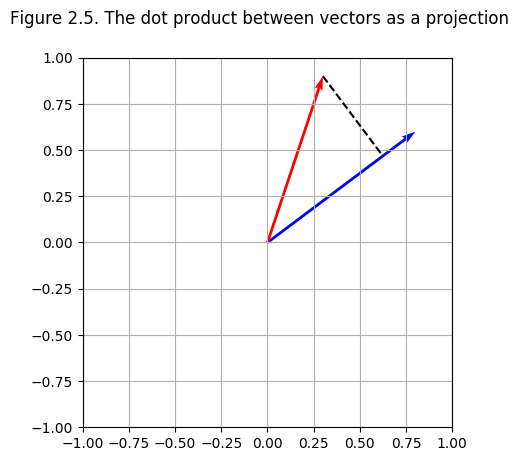

In [54]:
# 2D vectors that we will plot
a = [0.8, 3/5]
b = [0.3, 0.9]

dp = a'*b

# plotting the vectors
quiver(a[1],a[2],angles="xy", scale_units="xy", scale = 1, color="b")
quiver(b[1],b[2],angles="xy", scale_units="xy", scale = 1, color="r")
plot([b[1],(a.*dp)[1]],[b[2],(a.*dp)[2]],linestyle="--",color="k")
axis("scaled")
xlim((-1,1))
ylim((-1,1))
grid("on")

suptitle("Figure 2.5. The dot product between vectors as a projection");

In Figure 2.5 you can see how the black dotted line forms a rectangular triangle, whose right angle is at the intersection of the black dotted line and the blue line. The dot product is equal to the length of the blue line that falls within the triangle. 

To continue gaining intution about how the dot product works, we recommend playing with [this interactive applet](https://www.geogebra.org/m/G2yWterN) by [David Richeson](https://divisbyzero.com/) (Professor of Mathematics at Dickinson College), and also with [this other one](https://mathinsight.org/applet/dot_product_projection) by [Duane Q. Nykamp](http://www-users.math.umn.edu/~nykamp/) (Associate Professor of Mathematics at the University of Minnesota).

It is also important to note that the dot product and the Euclidean are somewhat similar. The Euclidean distance is a measurement of distance that does not take into account the direction of two vectors, while the dot product captures information about the magnitude and the direction (angle relationship between two vectors). Consider the following fact: the Euclidean distance between two vectors is equal to the dot product of the difference between those two vectors with itself.

But, why do neural networks choose the dot product and not the Eucledian distance to measure relationships between vectors? The short answer is: the dot product is much simpler to compute than the Eucledian distance, which requires us to square values and take calculate a square-root. However, the real answer is that neural networks can in fact use the Eucledian distance to measure relationships between vectors. In fact, there are other measurement metrics that neural networks may use (examples are the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity), [correlation](https://en.wikipedia.org/wiki/Correlation_and_dependence) and any other metric that indicates a relationship between two vectors). We will start using the dot product to measure the relationships between two vectors. This is convenient not only because of the simplicity of calculating the dot product, but also because a large number of modern and commonly used neural network architectures use the dot product.

### 2.3 Developing and Assessing a Naïve Classification Algorithm ###
In the previous section we used the Eucledian distance to identify datapoints in a two-dimensional feature space. Here we will repeat the excercise but this time we will use the dot product instead. Additionally, we will further formalize the preparation and assessment of this algorithm to classify data. 

First off, let's review the dataset that we are working with. The small version of the [IRMAS dataset](https://www.upf.edu/web/mtg/irmas) has recordings for four different instruments: 1) cello, 2) flute, 3) piano, and 4) human singing voice. For each instrument we have 35 two-second excerpts (140 datapoints total). The sampling rate is 22050 samples per second. The variable `data` contains audio snippets in a matrix with 140 rows and 44100 columns (a 140x44100 matrix). Each row of `data` contains a two-second audio snippets where a particular musical instrument is clearly heard. The variable `inst_cat` (short for "instrument category") contains numbers that tell us the instrument category that corresponds to each row of `data`. `inst_cat` is a matrix with 140 rows and 1 column (also refered to as a 140x1 column vector). In `inst_cat`, a 1 at the index `i` indicates that the corresponding `i`th row of `data` contains cello audio. A 2 indicates flute audio, a 3 indicates piano audio, and a 4 indicates human singing voice audio. The next cell reloads a fresh version of this dataset for you.

In [1]:
# loading a small version of the IRMAS dataset 
iris = matread("IRMAS_small.mat")
fs = 22050 # storing the sampling rate in a variable
T = 1/fs # and the timestep

# obtaining the data and corresponding instrument categories
data = iris["data"][:,1:end-1]
inst_cat = iris["data"][:,end];

The next step is to extract the features from this data in order to reduce its dimensionality. In the next cell, extract three features for all datapoints. Update the variable `data` to be a matrix of size 140x3.

In [2]:
# your code and borrowed code here


When we develop a classification algorithm, it is important to think how we will develop it and how we will assess it. The best practice is to "train" or develop the algorithm with the majority of the data and reserve a subsection of the data to "test" our algorithm when we decide that it is ready. Usually, around 90% of the data is randomly picked to train the algorithm and the remaining ~10% is used to test it. Although fully blind random separation of the training and test sets is ideal, when working with smaller datasets it is important to ensure that both training and test sets indeed have data for each data category that we want our algorithm to differentiate. In the following cell, separate the contents of the variable `data`  in a training and a test set.

In [3]:
# your code here (hint: use the function "sample" in the StatsBase package):

using StatsBase
# randomize numbers between 1 and 35
cell_rand_is = sample(1:35, 35, replace = false)
# randomize numbers between 36 and 70
flut_rand_is = sample(36:70, 35, replace = false)
# randomize numbers between 71 and 105
pian_rand_is = sample(71:105, 35, replace = false)
# randomize numbers between 105 and 140
hvoi_rand_is = sample(106:140, 35, replace = false)

# separate data to train
x_tr = [data[cell_rand_is[1:32],:]; data[flut_rand_is[1:32],:]; data[pian_rand_is[1:32],:]; data[hvoi_rand_is[1:32],:]]
y_tr = [inst_cat[cell_rand_is[1:32]]; inst_cat[flut_rand_is[1:32]]; inst_cat[pian_rand_is[1:32]]; inst_cat[hvoi_rand_is[1:32]]]

# separate data to test
x_ts = [data[cell_rand_is[33:end],:]; data[flut_rand_is[33:end],:]; data[pian_rand_is[33:end],:]; data[hvoi_rand_is[33:end],:]]
y_ts = [inst_cat[cell_rand_is[33:end]]; inst_cat[flut_rand_is[33:end]]; inst_cat[pian_rand_is[33:end]]; inst_cat[hvoi_rand_is[33:end]]];

Now that we have the data separated, we can train a classifier. We will start a very naïve classifier. We will use "average" vectors for each class of musical instruments to calculate the dot product between these "average" vectors and the datapoint vectors in the training set. It is important to note that the "average" vectors must be calculated using only the datapoints in the training set. 

In the next cell, find the "average" vectors for each class of musical instruments that we will use:

In [4]:
# using inst_cat_hat to identify the row indices of data that correspond to different instrument families.
cell_is = find(x -> x == 1,y_tr)
flut_is = find(x -> x == 2,y_tr)
pian_is = find(x -> x == 3,y_tr)
hvoi_is = find(x -> x == 4,y_tr)

# Calculate the average datapoints
cell_aver = mean(x_tr[cell_is,:],1)
flut_aver = mean(x_tr[flut_is,:],1)
pian_aver = mean(x_tr[pian_is,:],1)
hvoi_aver = mean(x_tr[hvoi_is,:],1);

The following cell will graph your datapoints and the "average" vectors in a 3D space.

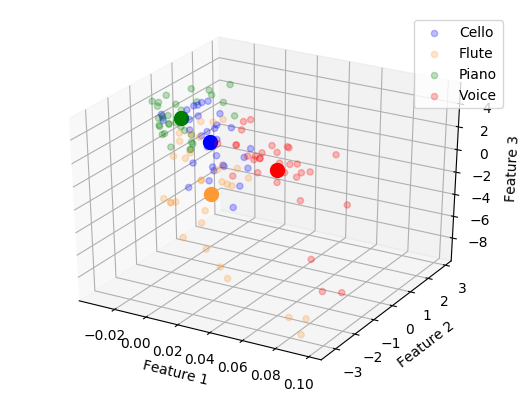

In [22]:
scatter3D(x_tr[cell_is,1],x_tr[cell_is,2],x_tr[cell_is,3], alpha = 0.25, color="b",label = "Cello")
scatter3D(cell_aver[1,1],cell_aver[1,2],cell_aver[1,3], s = 100, color="b")
scatter3D(x_tr[flut_is,1],x_tr[flut_is,2],x_tr[flut_is,3], alpha = 0.25, color=[1.0 0.6 0.2],label = "Flute")
scatter3D(flut_aver[1,1],flut_aver[1,2],flut_aver[1,3], s = 100, color=[1.0 0.6 0.2])
scatter3D(x_tr[pian_is,1],x_tr[pian_is,2],x_tr[pian_is,3], alpha = 0.25, color="g",label = "Piano")
scatter3D(pian_aver[1,1],pian_aver[1,2],pian_aver[1,3], s = 100,color="g")
scatter3D(x_tr[hvoi_is,1],x_tr[hvoi_is,2],x_tr[hvoi_is,3], alpha = 0.25, color="r",label = "Voice")
scatter3D(hvoi_aver[1,1],hvoi_aver[1,2],hvoi_aver[1,3], s = 100,color="r")
legend()
xlabel("Feature 1")
ylabel("Feature 2")
zlabel("Feature 3");

Now we can calculate the dot product between the "average" vectors and the datapoints. We will "vectorize" the calculation of the dot product to make this speed up this process. 

Let's start by explaining how to vectorize a dot product. Remember that the formula to calculate a dot product between two vectors $a, b \in \mathbf{R^{1xN}}$ is $ a \dot{} b = \sum_{i=1}^N a_i b_i$. "Vectorizing" a dot product only means that we will abbreviate this operation by using a different notation. The notation that indicates a vectorized dot product is:
$$a~b^T$$
Where the superscript T means that we are transposing the vector $b$ so that its dimensionality is $b^T \in \mathbf{R^{Nx1}}$. It is necessary to transpose the $b$ vector because the size of the second dimension of the first vector in the dot product must match the size of the first dimension of the second vector. This means that, because the second dimension of $a$ is of size $N$ we must transpose $b$ because the first dimension of $b^T$ is of size $N$ as well. The following expression illustrates how this operation works:
$$a~b^T = \begin{bmatrix} a_1 & a_2 & \dots & a_n \end{bmatrix} \begin{bmatrix} b_1\\b_2\\ \dots \\ b_n\end{bmatrix} = a_1b_1 + a_2b_2+\dots+a_nb_n$$

This operation is also possible when the first dimension of $a$ and $b$ are greater than $1$, which would make them be matrices. Matrices are usually noted as capital letters Let's start by consider the case when $A\in \mathbf{R^{MxN}}$ and $b\in \mathbf{R^{1xN}}$. This would result in:

$$A~b^T = \begin{bmatrix} a_{1,1} & a_{1,2} & \dots & a_{1,n} \\
                            a_{2,1} & a_{2,2} & \dots & a_{2,n} \\
                            \vdots  & \ddots & & \vdots \\
                            a_{m,1} & a_{m,2} & \dots & a_{m,n} \\
                            \end{bmatrix} \begin{bmatrix} b_1\\b_2\\ \dots \\ b_n\end{bmatrix} = 
                            \begin{bmatrix} a_{1,1}b_1 + a_{1,2}b_{2}+\dots+a_{1,n}b_n \\
                            a_{2,1}b_1 + a_{2,2}b_{2}+\dots+a_{2,n}b_n \\                            
                            \vdots\\
                            a_{m,1}b_1 + a_{m,2}b_{2}+\dots+a_{m,n}b_n \\
                            \end{bmatrix}$$

As you can see, the result of multiplying $A\in \mathbf{R^{MxN}}$ and $b\in \mathbf{R^{1xN}}$ is a vector $A~b^T \in \mathbf{R^{Mx1}}$, whose dimensions are the size of first dimension of $A$ by the size of the first dimension of $b$.

Now, for the sake of completion, let's consider the case when we want to calculate the dot product between $A\in \mathbf{R^{MxN}}$ and $B\in \mathbf{R^{LxN}}$:

$$A~B^T = \begin{bmatrix} a_{1,1} & a_{1,2} & \dots & a_{1,n} \\
                            a_{2,1} & a_{2,2} & \dots & a_{2,n} \\
                            \vdots  & \ddots & & \vdots \\
                            a_{m,1} & a_{m,2} & \dots & a_{m,n} \\
                            \end{bmatrix} 
          \begin{bmatrix} b_{1,1} & b_{2,1} & \dots & b_{l,1}\\
                            b_{1,2} & b_{2,2} & \dots & b_{l,2}\\
                            \vdots  & \ddots & & \vdots \\
                            b_{1,n} & b_{2,n} & \dots & b_{l,n}\\
                            \end{bmatrix} = 
          \begin{bmatrix} a_{1,1}b_{1,1} + a_{1,2}b_{1,2}+\dots+a_{1,n}b_{1,n} & a_{1,1}b_{2,1} + a_{1,2}b_{2,2}+\dots+a_{1,n}b_{2,n} & \dots & a_{1,1}b_{l,1} + a_{1,2}b_{l,2}+\dots+a_{1,n}b_{l,n}  \\
                          a_{2,1}b_{1,1} + a_{2,2}b_{1,2}+\dots+a_{2,n}b_{1,n} & a_{2,1}b_{2,1} + a_{2,2}b_{2,2}+\dots+a_{2,n}b_{2,n} & \dots & a_{2,1}b_{l,1} + a_{2,2}b_{l,2}+\dots+a_{2,n}b_{l,n}  \\  
                            \vdots  & \ddots & & \vdots \\
                          a_{m,1}b_{1,1} + a_{m,2}b_{1,2}+\dots+a_{m,n}b_{1,n} & a_{m,1}b_{2,1} + a_{m,2}b_{2,2}+\dots+a_{m,n}b_{2,n} & \dots & a_{m,1}b_{l,1} + a_{m,2}b_{l,2}+\dots+a_{m,n}b_{l,n}  \\  
                            \end{bmatrix}$$

The result of multiplying $A\in \mathbf{R^{MxN}}$ and $B\in \mathbf{R^{LxN}}$ is a matrix $A~B^T \in \mathbf{R^{MxL}}$. By realizing that in this last expression we calculated $MxL$ dot products with a single matrix multiplication, you can see why this notation is so useful to abbreviate multiple dot products. 

Now that we know how to vectorize dot products between vectors and matrices, let's now return to our classifier. The goal is to compute the inner product between three-dimensional "average" vectors of instruments and three-dimensional datapoints. To exploit the notation we just learned, we can make our operations quicker by staking our "average" vectors to form a 4 by 3 matrix. Do this in the following cell and call the resulting matrix $W$:

In [20]:
# your code here:


We now have a matrix $W \in \mathbf{R^{4x3}}$ whose rows are the "average" vectors for each instrument class that we want to classify. 

What else do we have? We also have a matrix `x_tr` with dimensions `128x3`. If we multiply `x_tr` and `W'`, we will obtain a matrix with dimensions `128x4`, whose rows will correspond to the result of the dot product between each  datapoints and the four "average" vectors. For each datapoint, we want the classifier to identify which "average" vector resulted in the largest dot product to naïvely say that the datapoint corresponts to that instrument category. 

In the next cell compute the dot product between `x_tr` and `W`. Store the result in a variable called `products`. Then, for each row identify which column contains the largest dot product. Store the column number containing the largest dot product for each datapoint in a variable called `y_tr_hat`.

The next cell will compute the accuracy of the algorithm on the training set:

In [25]:
print("Training accuracy: ", 100*sum(y_tr .== y_tr_hat')/length(y_tr), " %")

Training accuracy: 61.71875 %

We are done with training our algorithm. In fact, because our algorithm is so naïve, all we needed to do to train our algorithm was finding the `W` matrix containing the stacked "average" vectors.

Now we have to assess its accruacy with the test data. Use the next cell to do that.

Test accuracy: 66.66666666666667 %